In [1]:
from typing import List, Dict, Set
import attrs
import sympy

import qualtran.testing as qlt_testing
from qualtran import (
    Bloq, BloqBuilder,
    QBit, QAny, QInt, QUInt,
    Register, Side, Signature,
)

from qualtran.resource_counting import BloqCountT, SympySymbolAllocator
from qualtran.symbolics import SymbolicInt
from qualtran.drawing import show_bloq, show_call_graph
from qualtran.simulation.classical_sim import ClassicalValT
from qualtran.bloqs.factoring import CtrlModMul

In [2]:
@attrs.frozen
class ModExp(Bloq):
    """Perform modular exponentiation `x = g^exponent mod p`.

    x and exponent are quantum variables; g and the modulus are classical constants.

    The exponent register has `n_exponent` bits.

    For simplicity, let's assume
        - a 32-bit "x" register.
    """

    g: int
    mod: int
    n_exponent: SymbolicInt = 4

    @property
    def signature(self) -> 'Signature':
        return Signature([
            Register('exponent', QUInt(bitsize=self.n_exponent)),
            Register('x', QUInt(bitsize=32), side=Side.RIGHT)
        ])

    def build_composite_bloq(self, bb: 'BloqBuilder', exponent):
        # Use `bb.add(subbloq, arg=val, arg=val)` to "wire up" a circuit for modular exponentiation.
        # The system will pass in a quantum variable, `exponent` that can be split into bits,
        # passed into subbloqs, and returned as output variables.
        #
        # Algorithm steps:
        #  1. initialize the output register in the |1> state
        #  2. Use each bit of the exponent register to control a CtrlModMul operation, where
        #     the multiplicative constant is g^2^j for bit index j
        #  3. Return the exponent and x register in accordance with this bloq's signature.

        # Hints:
        from qualtran.bloqs.basic_gates import IntState
        # https://qualtran.readthedocs.io/en/latest/bloqs/basic_gates/states_and_effects.html#intstate
        from qualtran.bloqs.factoring import CtrlModMul
        # https://qualtran.readthedocs.io/en/latest/bloqs/factoring/mod_mul.html
        from qualtran.bloqs.bookkeeping import Split, Join
        # or, `soqs = bb.split(soq)` and `soq = bb.join(soqs, dtype)`

        # ! -------------------------------
        x = bb.add(IntState(val=1, bitsize=32))
        exponent = bb.split(exponent)

        base = self.g
        for j in range(self.n_exponent - 1, 0 - 1, -1):
            cmod_mul = CtrlModMul(k=base, bitsize=32, mod=self.mod)
            exponent[j], x = bb.add(cmod_mul, ctrl=exponent[j], x=x)
            base = base * base % self.mod  # next power of two

        exponent = bb.join(exponent, dtype=QUInt(self.n_exponent))
        return {'exponent': exponent, 'x': x}
        # ! -------------------------------

    def on_classical_vals(
            self, exponent: 'ClassicalValT',
    ) -> Dict[str, 'ClassicalValT']:
        return {
            'exponent': exponent,
            'x': (self.g ** exponent) % self.mod
        }

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        k = ssa.new_symbol('k')
        return {
            (CtrlModMul(k=k, mod=self.mod, bitsize=32), self.n_exponent)
        }

In [3]:
mod_exp = ModExp(g=7, mod=15)
mod_exp_decomp = qlt_testing.assert_valid_bloq_decomposition(mod_exp)

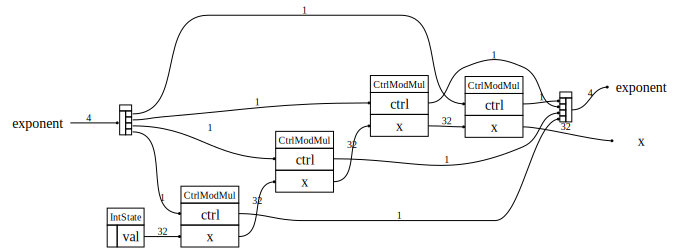

In [6]:
show_bloq(mod_exp_decomp)

In [4]:
mod_exp = ModExp(g=7, mod=15)
mod_exp_decomp = mod_exp.decompose_bloq()
for exponent in range(10):
    ref_out = mod_exp.call_classically(exponent=exponent)
    decomp_out = mod_exp_decomp.call_classically(exponent=exponent)
    assert ref_out == decomp_out
    print('ref', ref_out, 'decomp', decomp_out)

ref (0, 1) decomp (0, 1)
ref (1, 7) decomp (1, 7)
ref (2, 4) decomp (2, 4)
ref (3, 13) decomp (3, 13)
ref (4, 1) decomp (4, 1)
ref (5, 7) decomp (5, 7)
ref (6, 4) decomp (6, 4)
ref (7, 13) decomp (7, 13)
ref (8, 1) decomp (8, 1)
ref (9, 7) decomp (9, 7)
